In [20]:
import time

import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import Adam

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss 
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn import neighbors, svm, tree, linear_model, ensemble, neural_network, metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score, cohen_kappa_score,\
classification_report, log_loss, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC

#########################################################################

%matplotlib inline
pd.set_option("max_columns",90, "max_rows", 90)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys 
sys.path.insert(0, 'C:\\Users\\qzhang\\PycharmProjects\\Mei')
from utility import model_fit

from sklearn.preprocessing import StandardScaler

def data_prep(raw_df):
    """"""
    df = raw_df.copy()
    
    JUD_ST = ('CT', 'DE', 'FL', 'IL', 'IN', 'KS', 'KY', 'LA', 'ME', 'MA',
              'NE', 'NJ', 'NM', 'NY', 'ND', 'OH', 'OK', 'PA', 'SC', 'SD',
              'VT', 'WI')
    CATE_VAR = ['orig_chn', 'loan_purp', 'prop_type', 'occ_stat', 'judicial_st', 'fhb_flag']

    # drop columns
    df.drop(['loan_id', 'status_prev', 'msa'], axis=1, inplace=True)

    # drop all the observation with missing value
    df.dropna(how='any', inplace=True)

    # create a new feature based on prop_state
    df.loc[:, 'judicial_st'] = df['prop_state'].apply(lambda x: 'Y' if x in JUD_ST else 'N')
    df.drop(['prop_state'], axis=1, inplace=True)

    # convert status to 0 or 1
    df.loc[:, 'status'] = df['status'].apply(lambda x: int(x == 'D60-D90'))

    X = df.drop(['status'], axis=1).copy()
    num_feats = list(set(X.columns) - set(CATE_VAR))
    X.loc[:, num_feats] = StandardScaler().fit(X[num_feats]).transform(X[num_feats])
    X = pd.get_dummies(X, columns=CATE_VAR)
    y = df['status'].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    return X_train, X_test, y_train, y_test

# read data
raw_df = pd.read_csv('..\Data\Gse_panel_current_sample_raw.csv')

# split sample set
X_train, X_test, y_train, y_test = data_prep(raw_df)


In [22]:
X_train = X_train.values
y_train = y_train.values

## Over-sampling via SMOTE

In [34]:
# over-sampling
sm = SMOTE(ratio='minority', random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

## Under-sampling via NearMiss

In [23]:
nm = NearMiss(ratio='auto', random_state=42)
X_res, y_res = nm.fit_sample(X_train, y_train)

### logistic regression

Accuracy = 0.7928733333333333


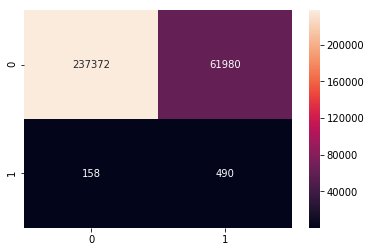

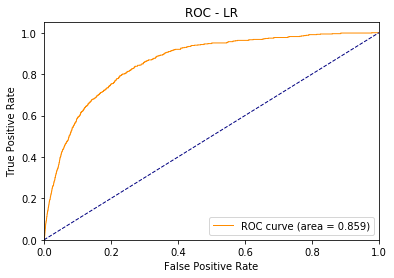

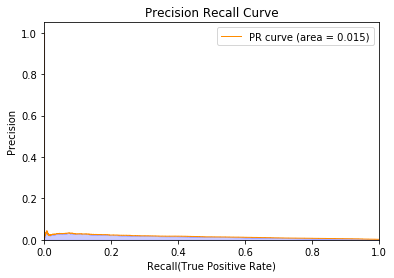

cohen's kappa:  0.01129913657764603
             precision    recall  f1-score   support

          0       1.00      0.79      0.88    299352
          1       0.01      0.76      0.02       648

avg / total       1.00      0.79      0.88    300000



In [13]:
# train and predict
lr = linear_model.LogisticRegression(C=10, penalty='l1')
y_lr = model_fit(lr, X_res, X_test, y_res, y_test, display=True)

### Naive Bayes

Accuracy = 0.6834866666666667


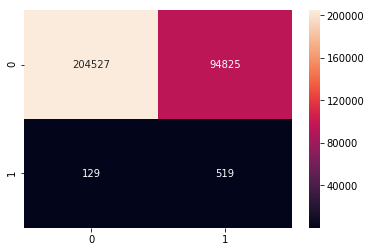

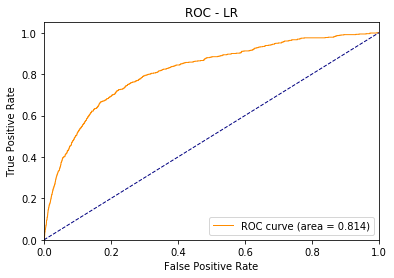

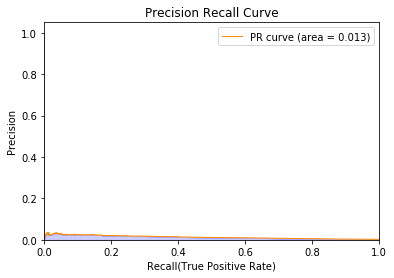

cohen's kappa:  0.006550671413972808
             precision    recall  f1-score   support

          0       1.00      0.68      0.81    299352
          1       0.01      0.80      0.01       648

avg / total       1.00      0.68      0.81    300000



In [14]:
nb = GaussianNB()
y_nb = model_fit(nb, X_res, X_test, y_res, y_test, display=True)

### AdaBoost

Accuracy = 0.99441


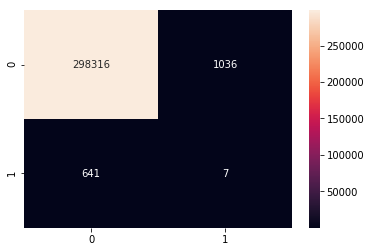

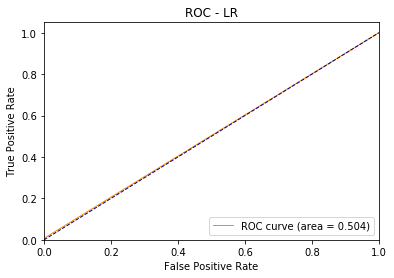

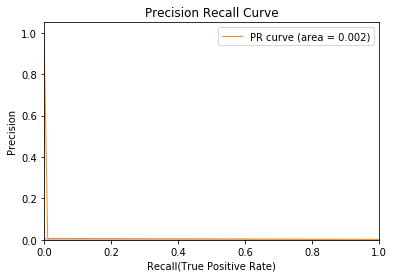

cohen's kappa:  0.005629571554303103
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    299352
          1       0.01      0.01      0.01       648

avg / total       1.00      0.99      1.00    300000



In [15]:
bdt = AdaBoostClassifier(tree.DecisionTreeClassifier(), algorithm="SAMME.R", n_estimators=100,learning_rate=0.01)
y_bdt = model_fit(bdt, X_res, X_test, y_res, y_test, display=True)

### Gradient Boost

Accuracy = 0.9977433333333333


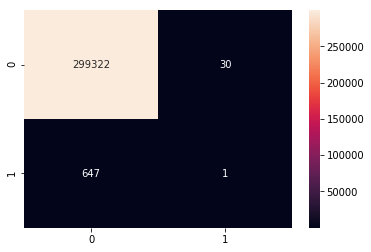

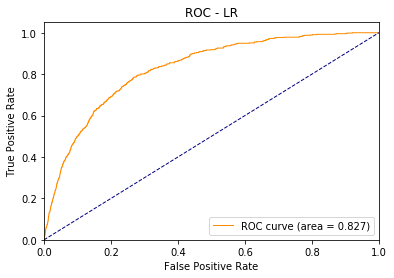

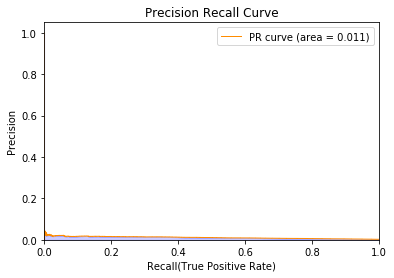

cohen's kappa:  0.0027488190306990123
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    299352
          1       0.03      0.00      0.00       648

avg / total       1.00      1.00      1.00    300000



In [16]:
gb = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, 
                                 subsample=0.6, min_samples_split=50, min_samples_leaf=50,
                                 max_depth=2, random_state=0, verbose=0)
y_gb = model_fit(gb, X_res, X_test, y_res, y_test, display=True)

### SVM

In [ ]:
sv = SVC(kernel="rbf", C=0.5, probability=True)
y_svm = model_fit(sv, X_res, X_test, y_res, y_test, display=True)

## Stacker

In [7]:
# Some useful parameters which will come in handy later on
ntrain = X_res.shape[0]
ntest = X_test.shape[0]
SEED = 2018 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        try:
            params['random_state'] = seed
            self.clf = clf(**params)
        except:
            print("no random_state")
            self.clf = clf()
        

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [8]:
def get_oof_train(clf, x_train, y_train):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)

    return oof_train.reshape(-1, 1)

def get_oof_test(clf, X_res, y_res, X_test):
    clf.train(X_res, y_res)
    return clf.predict(X_test)

In [9]:
tic = time.time()
lr = SklearnHelper(linear_model.LogisticRegression, seed=0, params={'C': 1, 'penalty': 'l2'})
nb = SklearnHelper(GaussianNB)
base_clf = tree.DecisionTreeClassifier(random_state=11, splitter='random', min_samples_split=1200, min_samples_leaf=70, max_depth=8, criterion='entropy', max_features="auto")
param_adb = {'clf': base_clf, 'algorithm': "SAMME.R", 'n_estimators': 90, 'learning_rate': 0.1}
adb = SklearnHelper(AdaBoostClassifier, seed=0, params=param_adb)

lr_oof_train = get_oof_train(lr, X_res, y_res)
nb_oof_train = get_oof_train(nb, X_res, y_res)
adb_oof_train = get_oof_train(adb, X_res, y_res)

lr_oof_test = get_oof_test(lr, X_res, y_res, X_test)
nb_oof_test = get_oof_test(nb, X_res, y_res, X_test)
adb_oof_test = get_oof_test(adb, X_res, y_res, X_test)


no random_state
no random_state


In [10]:
train_meta = pd.DataFrame( {'LogisticRegression': lr_oof_train.ravel(),
                            'GaussianNB': nb_oof_train.ravel(),
                            'AdaBoost': adb_oof_train.ravel(), }).astype(int)
test_meta = pd.DataFrame( {'LogisticRegression': lr_oof_test.ravel(),
                           'GaussianNB': nb_oof_test.ravel(),
                           'AdaBoost': adb_oof_test.ravel(), })

Time cost: 20433.863298654556 seconds
Accuracy = 0.9940066666666667


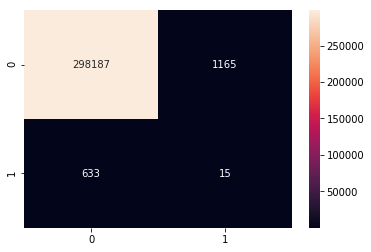

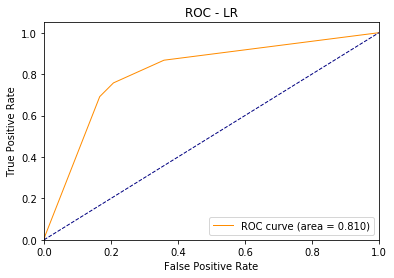

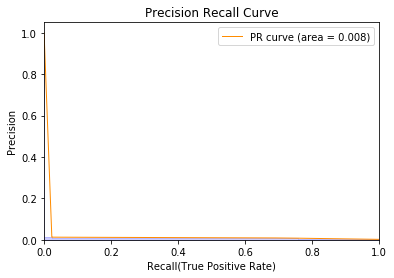

cohen's kappa:  0.013660852056588402
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    299352
          1       0.01      0.02      0.02       648

avg / total       1.00      0.99      0.99    300000



array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [11]:
lr_meta = linear_model.LogisticRegression()
toc = time.time()
print(f"Time cost: {toc-tic} seconds")
model_fit(lr_meta, train_meta, test_meta, y_res, y_test, display=True)


In [99]:
1e-5

1e-05

## 2-layers Neural Network

In [2]:
X_train.shape

(699984, 46)

In [27]:
model = Sequential()
model.add(Dense(30, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())
b_size=256
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=b_size, shuffle=True, verbose=2, class_weight={0:1, 1:10})  # , class_weight={0:1, 1:10}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 30)                1410      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 1,731
Trainable params: 1,731
Non-trainable params: 0
_________________________________________________________________
None
Train on 559987 samples, validate on 139997 samples
Epoch 1/30
 - 4s - loss: 0.1466 - acc: 0.9906 - val_loss: 0.0958 - val_acc: 0.9978
Epoch 2/30
 - 4s - loss: 0.0890 - acc: 0.9978 - val_loss: 0.0904 - val_acc: 0.9977
Epoch 3/30
 - 4s - loss: 0.0860 - acc: 0.9978 - val_loss: 0.0888 - val_acc: 0.9977
Epoch 4/30
 - 4s - loss: 0.0850 - acc: 0.9977 - val_loss: 0.0882 - val_acc: 0.9977
Epoch 5/30
 - 4

In [28]:
# history = model.fit(X_train, y_train, validation_split=0.2, initial_epoch=30, epochs=40, batch_size=b_size, shuffle=True, verbose=2)

299994/299994 [==============================] - 2s 5us/step
['loss', 'acc'] [0.02730240698104609, 0.9976332859863374]


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Classifier': 'Neural Networks', 'PR_AUC': 0.01782486262033849, 'ROC_AUC': 0.8538071623010265, 'Expeted num of D60-D90': 5942.2314, 'Actual num of D60-D90': 664, 'F score': 0.02384858044164038, 'G mean': 0.7148220514127578}


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


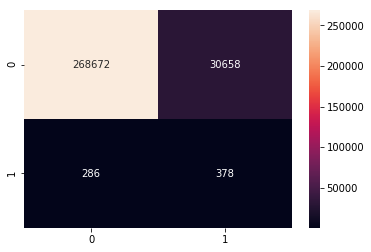

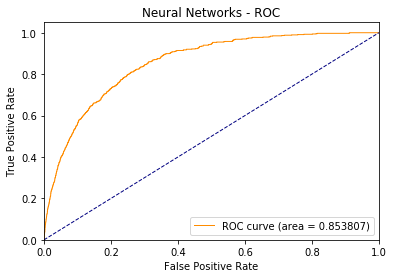

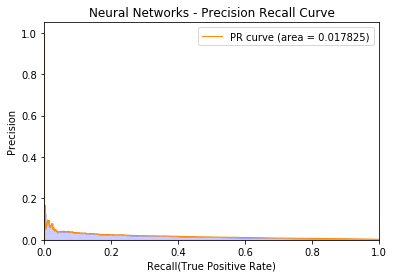

In [29]:
# evaluat - return loss and any other metrics requested, batch size should as large as possible when evaluating or predicting
scores = model.evaluate(X_test, y_test, batch_size=b_size)   
print(model.metrics_names, scores)

# predict 
prob_pos = model.predict(X_test, batch_size=b_size, verbose=0) 
vfunc = np.vectorize(lambda x: 1 if x > 0.05 else 0)
y_pred = vfunc(prob_pos)
# sns.heatmap(confusion_matrix(y_test, model.predict_classes(X_test, batch_size=400, verbose=0)), annot=True, fmt="d")

# calculate related metrics
precision, recall, _ = precision_recall_curve(y_test, prob_pos)
fpr, tpr, _ = roc_curve(y_test, prob_pos)
roc_auc = auc(fpr, tpr)
pr_auc = average_precision_score(y_test, prob_pos)
exp_pos = np.sum(prob_pos)
f_score = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

op = {'Classifier': 'Neural Networks',
      'PR_AUC': pr_auc,
      'ROC_AUC': roc_auc,
      'Expeted num of D60-D90': exp_pos,
      'Actual num of D60-D90': np.sum(y_test),
      'F score': f_score,
      'G mean': g_mean}
print(op)

# PLOT - confusion matrix
ax_cm = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

# PLOT - ROC_AUC
fig_ra = plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Neural Networks - ROC')
plt.legend(loc="lower right")
fig_ra.show()

# PLOT - PR_AUC
fig_pr = plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1,
         label='PR curve (area = %0.6f)' % pr_auc)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title(f'Neural Networks - Precision Recall Curve')
plt.legend(loc="upper right")


fig_pr.show()

# {'Classifier': 'Neural Networks', 'PR_AUC': 0.018236309507601578, 'ROC_AUC': 0.8498468844475554, 'Expeted num of D60-D90': 5715.9766, 'Actual num of D60-D90': 664, 'F score': 0.023541653118293555, 'G mean': 0.700739626845605}
# {'Classifier': 'Neural Networks', 'PR_AUC': 0.017018686309638778, 'ROC_AUC': 0.8505524813650084, 'Expeted num of D60-D90': 614.0507, 'Actual num of D60-D90': 664, 'F score': 0.045569620253164564, 'G mean': 0.20148335637766554}

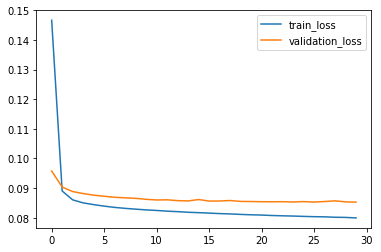

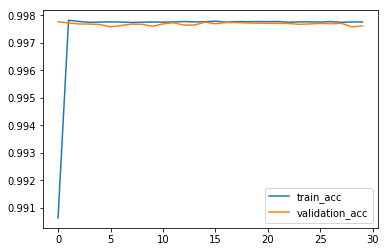

In [30]:
h = history.history

plt.figure()
plt.plot(h['loss'], label='train_loss')
plt.plot(h['val_loss'], label='validation_loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(h['acc'], label='train_acc')
plt.plot(h['val_acc'], label='validation_acc')
plt.legend()
plt.show()


In [31]:
h

{'val_loss': [0.0957681301599387,
  0.09035555403442916,
  0.08883507430561526,
  0.08815778014590006,
  0.08761970372246232,
  0.08724657119936637,
  0.08690523199536807,
  0.08670963585019956,
  0.08654299751187547,
  0.08621360173381025,
  0.08599191738086788,
  0.08604266850631333,
  0.0857679639746983,
  0.08566184533317019,
  0.0861438733212051,
  0.08561831915499997,
  0.08564394685071972,
  0.08580517527775196,
  0.08550201704232824,
  0.0854664235648073,
  0.08540572720531858,
  0.08537995804707692,
  0.08541081834030752,
  0.08529949157460864,
  0.08544807139922549,
  0.08528191572719947,
  0.08546481067262256,
  0.08570137870072292,
  0.08534558968572889,
  0.08526841121950704],
 'val_acc': [0.9977642378059474,
  0.9977213797447032,
  0.9976856646936664,
  0.997678521683459,
  0.9976642356630443,
  0.997578519540556,
  0.9976285206120075,
  0.997678521683459,
  0.9976713786732516,
  0.9975999485711781,
  0.9976856646936664,
  0.9977285227549105,
  0.9976428066324222,
  0.997

C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Classifier': 'Neural Networks Training Set', 'PR_AUC': 0.02557305850117107, 'ROC_AUC': 0.8770363911552918, 'Expeted num of D60-D90': 13902.864, 'Actual num of D60-D90': 1532, 'F score': 0.026028671998273748, 'G mean': 0.7518487556498239}


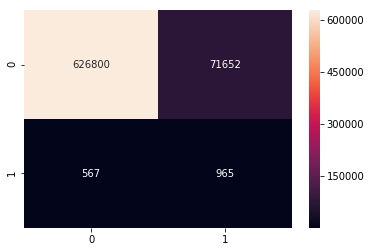

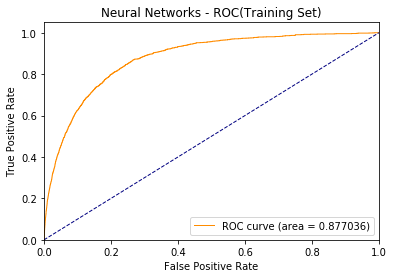

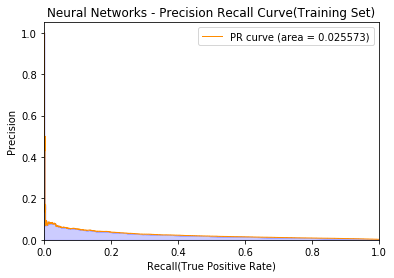

In [32]:
# predict 
prob_pos = model.predict(X_train, batch_size=b_size, verbose=0) 
vfunc = np.vectorize(lambda x: 1 if x > 0.05 else 0)
y_pred = vfunc(prob_pos)

# calculate related metrics
precision, recall, _ = precision_recall_curve(y_train, prob_pos)
fpr, tpr, _ = roc_curve(y_train, prob_pos)
roc_auc = auc(fpr, tpr)
pr_auc = average_precision_score(y_train, prob_pos)
exp_pos = np.sum(prob_pos)
f_score = f1_score(y_train, y_pred)
g_mean = geometric_mean_score(y_train, y_pred)

op = {'Classifier': 'Neural Networks Training Set',
      'PR_AUC': pr_auc,
      'ROC_AUC': roc_auc,
      'Expeted num of D60-D90': exp_pos,
      'Actual num of D60-D90': np.sum(y_train),
      'F score': f_score,
      'G mean': g_mean}
print(op)

# PLOT - confusion matrix
ax_cm = sns.heatmap(confusion_matrix(y_train, y_pred), annot=True, fmt="d")

# PLOT - ROC_AUC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.6f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Neural Networks - ROC(Training Set)')
plt.legend(loc="lower right")
plt.show()

# PLOT - PR_AUC
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=1,
         label='PR curve (area = %0.6f)' % pr_auc)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall(True Positive Rate)')
plt.ylabel('Precision')
plt.title(f'Neural Networks - Precision Recall Curve(Training Set)')
plt.legend(loc="upper right")
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 46)                2162      
_________________________________________________________________
dense_5 (Dense)              (None, 48)                2256      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 98        
Total params: 4,516
Trainable params: 4,516
Non-trainable params: 0
_________________________________________________________________
None
Train on 559987 samples, validate on 139997 samples
Epoch 1/20
 - 40s - loss: 0.0169 - acc: 0.9978 - val_loss: 0.0140 - val_acc: 0.9978
Epoch 2/20
 - 18s - loss: 0.0135 - acc: 0.9978 - val_loss: 0.0138 - val_acc: 0.9978
Epoch 3/20
 - 21s - loss: 0.0132 - acc: 0.9978 - val_loss: 0.0138 - val_acc: 0.9978
Epoch 4/20
 - 15s - loss: 0.0131 - acc: 0.9978 - val_loss: 0.0137 - val_acc: 0.9978
Epoch 5/20


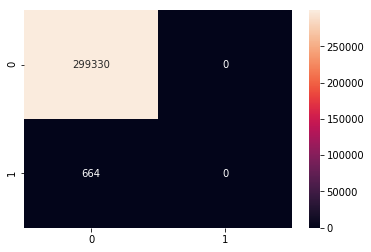

In [25]:
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(X_train.shape[1]+2, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())
model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=600, shuffle=True, verbose=2)
#scores = model.evaluate(X_test, y_test, batch_size=512)

#print("\n%s: %.2f%%" % (model.metrics_names[0], scores[0]*100))
#print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
y_pred = model.predict(X_test, batch_size=400, verbose=0)
#vfunc = np.vectorize(lambda x: 1 if x > 0.5 else 0)
#sns.heatmap(confusion_matrix(y_test, vfunc(y_pred)), annot=True, fmt="d")
sns.heatmap(confusion_matrix(y_test, model.predict_classes(X_test, batch_size=400, verbose=0)), annot=True, fmt="d")